### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.model_selection import validation_curve, train_test_split
from joblib import dump, load
import pickle
import copy
import gc
import os

from helpers import helpfunction as helper

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
input_dir = "./input/March2020/"
output_dir = "./output/"
model_dir = "./models/"

<IPython.core.display.Javascript object>

In [5]:
x_sce_magic = 1.03
grouper = ["sample", "Run", "event"]

<IPython.core.display.Javascript object>

In [6]:
retrain = False
train_ana = True
seed = 7
test_size = 0.25
lee_focus = 1.0

<IPython.core.display.Javascript object>

In [7]:
train_sample = "train_new"
plot_samples = ["on", "off", "nu", "dirt"]

<IPython.core.display.Javascript object>

### Load Samples

In [8]:
%%time
train = pickle.load(open(input_dir+"{}_slimmed.pckl".format(train_sample), 'rb'))

available_samples = os.listdir(input_dir)
all_samples = {
    s: pickle.load(open(input_dir+min([f for f in available_samples if s in f], key=len), 'rb')) for s in plot_samples
}
all_samples['train'] = train

CPU times: user 2.75 s, sys: 5.67 s, total: 8.42 s
Wall time: 13.6 s


<IPython.core.display.Javascript object>

In [9]:
print("Training set constructed with {} entries.".format(train["numentries"]))

Training set constructed with 2743560 entries.


<IPython.core.display.Javascript object>

### Explore Tree

In [10]:
fields = all_samples["dirt"]["fields"]
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [11]:
# trk_fields

<IPython.core.display.Javascript object>

In [12]:
# shr_fields

<IPython.core.display.Javascript object>

In [13]:
# backracked_fields

<IPython.core.display.Javascript object>

In [14]:
# other_fields

<IPython.core.display.Javascript object>

In [15]:
# search through fields:
[f for f in fields if "CosmicIP" in f]

['CosmicIP', 'CosmicIPAll2DEnds', 'CosmicIPAll2DOvlp', 'CosmicIPAll3D']

<IPython.core.display.Javascript object>

In [16]:
train["daughters"].keys()

Index(['run', 'sub', 'evt', 'topological_score', 'n_pfps', 'n_showers',
       'n_tracks', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y',
       'reco_nu_vtx_sce_z', 'reco_nu_vtx_x', 'reco_nu_vtx_y', 'reco_nu_vtx_z',
       'crtveto', 'crthitpe', 'slclustfrac', 'nu_flashmatch_score', 'slpdg',
       'SliceCaloEnergy2', 'NeutrinoEnergy2', 'secondshower_Y_nhit',
       'secondshower_Y_vtxdist', 'secondshower_Y_dot', 'secondshower_Y_dir',
       'secondshower_Y_eigenratio', 'hits_ratio', 'contained_fraction',
       'n_showers_contained', 'n_tracks_contained', 'shrclusdir2',
       'shrclusfrac2', 'CosmicIP', 'CosmicIPAll3D', 'CosmicDirAll3D',
       'ismerged', 'merge_bestdot', 'merge_bestdist', 'trkshrhitdist2',
       'trk_score_v', 'trk_distance_v', 'trk_theta_v', 'trk_phi_v',
       'trk_len_v', 'trk_llr_pid_score_v', 'trk_mcs_muon_mom_v',
       'trk_range_muon_mom_v', 'trk_energy_proton_v', 'trk_calo_energy_y_v',
       'trk_sce_end_x_v', 'trk_sce_end_y_v', 'trk_sce_end_z_v',
       'tr

<IPython.core.display.Javascript object>

In [17]:
train["mc"].keys()

dict_keys(['mc_pdg', 'mc_E', 'lep_e', 'ccnc', 'theta', 'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z', 'n_pfps', 'interaction', 'weightSpline', 'weightSplineTimesTune', 'leeweight', 'nu_e', 'nu_pdg', 'nelec', 'npion', 'npi0', 'nproton', 'nmuon', 'nu_completeness_from_pfp', 'nu_purity_from_pfp', 'nueccinc', 'Run', 'sample', 'filter'])

<IPython.core.display.Javascript object>

### Provide the correct scaling

In [18]:
pot_scale = all_samples["on"]["pot"] / 1e21

<IPython.core.display.Javascript object>

In [19]:
all_samples["dirt"]["mc"]["event_scale"] = np.full(
    len(all_samples["dirt"]["mc"]["Run"]),
    all_samples["on"]["pot"] / sum(all_samples["dirt"]["pot"].values()),
)

<IPython.core.display.Javascript object>

### Add fields

In [20]:
%%time
# For all samples
for k, v in all_samples.items():
    print(k)
    v['daughters']['shr_energy_y_v']/=0.81 # calibration of shower energy.
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
       helper.is_fid(
           *v["daughters"][
               ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
           ]
           .xs(0, level="daughter")
           .values.T
       ),
       v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby(grouper, sort=False).transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby(grouper, sort=False).transform(min)
    )
    # Add pfp at vtx:
    v["daughters"]["n_pfpvtx"] = v["daughters"].eval("trk_distance_v<3 & trk_distance_v>=0")
    v["daughters"]["n_pfpvtx"] = v["daughters"]['n_pfpvtx'].groupby(grouper, sort=False).transform(sum)
    v["daughters"]["n_pfp_farvtx"] = v["daughters"].eval("n_pfps-n_pfpvtx")

    v["daughters"]['secondshower_Y_anglediff'] = v["daughters"].eval('abs(secondshower_Y_dir-shrclusdir2)')
    # Add electron candidate check
    e_cand_str = 'pfpplanesubclusters_U>0 & pfpplanesubclusters_V>0 & pfpplanesubclusters_Y>0 & \
                  trk_score_v<0.25 & shr_tkfit_dedx_nhits_y_v>0 & pfp_generation_v==2 & trk_llr_pid_score_v>0.02'    

    e_cand_bool = v["daughters"].eval(e_cand_str)
    e_cand_maxe = v["daughters"][e_cand_bool]["shr_energy_y_v"].groupby(grouper, sort=False).transform(max) == v["daughters"][e_cand_bool]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    # Add weighted dedx:
    dedx_cols = ["shr_tkfit_dedx_u_v",
                   "shr_tkfit_dedx_v_v",
                   "shr_tkfit_dedx_y_v",
                   'shr_tkfit_nhits_v',
                   "shr_tkfit_dedx_nhits_u_v",
                   "shr_tkfit_dedx_nhits_v_v",
                   "shr_tkfit_dedx_nhits_y_v"]
    v["daughters"][dedx_cols]=v["daughters"][dedx_cols].clip(lower=0, upper=20)
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/\
                            (shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    # Add the number of hits per length:
    v["daughters"]['hits_per_tklen_v']= v["daughters"].eval('pfnhits/trk_len_v')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_subclusters_v']= v["daughters"].eval('pfpplanesubclusters_U+pfpplanesubclusters_V+pfpplanesubclusters_Y')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_tkfit_hitratio_v']= v["daughters"].eval('shr_tkfit_nhits_v/pfnhits')
    # Explore mcs muon momentum:
    v["daughters"]['trk_muon_hypothesis_ratio_v']= v["daughters"].eval('trk_mcs_muon_mom_v/trk_range_muon_mom_v')
    
    # Add muon veto:
    q_muon_select = "(trk_llr_pid_score_v>0.4 & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4)"
    v["daughters"]['mu_candidate']= v["daughters"].eval(q_muon_select)
    v["daughters"]["mu_candidate_event"] = v["daughters"]['mu_candidate'].groupby(grouper, sort=False).transform(max)

on
off
nu


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


dirt
train
CPU times: user 39.8 s, sys: 6.42 s, total: 46.2 s
Wall time: 29.5 s


<IPython.core.display.Javascript object>

In [21]:
%%time
# For MC samples
for k, v in all_samples.items():
    if k not in helper.data_samples:
        # Add distance between reco_sce and true vertex
        
        true_vtx = [v['mc'][f][v['mc']['n_pfps']>0] for f in ["true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z"]]
        reco_vtx = v["daughters"][[
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z"]].xs(0, level="daughter").values.T
        reco_vtx[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        v["daughters"]["true_vtx_distance"] = np.repeat(np.linalg.norm(true_vtx - reco_vtx, axis=0),v['mc']['n_pfps'][v['mc']['n_pfps']>0])
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0
        
        ## add truth weights:
        add_mc_fields = ['interaction',  'weightSplineTimesTune', 'leeweight', 'nu_e', 'nu_pdg', 'nueccinc', 'npion', 'npi0', 'nproton',"nelec", "nmuon", "nu_purity_from_pfp"]
        if k != 'train':
            add_mc_fields.append('event_scale')
        for true_f in add_mc_fields:
            v['daughters'][true_f] = np.repeat(v['mc'][true_f],v['mc']['n_pfps'])

CPU times: user 13.5 s, sys: 5.45 s, total: 19 s
Wall time: 10.9 s


<IPython.core.display.Javascript object>

In [22]:
%%time
# Add training labels and weights
e_cand = train["daughters"]['e_candidate']
e_good = train["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.8 & backtracked_completeness>0.8 & true_vtx_distance<5')
e_cand_bad = train["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11') 
other_bad = train["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==0)')
other_neutral = train["daughters"].eval('~e_candidate & (backtracked_pdg==22 | abs(backtracked_pdg)==211)')
train["daughters"]['train_weight'] = train["daughters"].eval('weightSplineTimesTune+leeweight*@lee_focus') # weight low energy electrons a bit higher
train["daughters"]['train_weight'] = train["daughters"].eval('train_weight*(1+(shr_energy_y_v<600)*@lee_focus*e_candidate)') # weight low energy electrons a bit higher
train["daughters"].loc[e_good, "train_weight"] *= 2 # can be tuned
train["daughters"].loc[other_neutral, "train_weight"] = 1 # can be tuned

train["daughters"]['train_label'] = 1
train["daughters"].loc[e_cand_bad, "train_label"] = 0
train["daughters"].loc[other_bad, "train_label"] = 0
train["daughters"].loc[other_neutral, "train_label"] = 0

CPU times: user 3.74 s, sys: 1.23 s, total: 4.97 s
Wall time: 2.56 s


<IPython.core.display.Javascript object>

In [23]:
gc.collect

<function gc.collect(generation=2)>

<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [24]:
query_preselect = "e_candidate & \
                   reco_fid_vol & \
                   shr_energy_y_v>100 & \
                   CosmicIPAll3D>30 & \
                   CosmicDirAll3D>-0.98 & \
                   CosmicDirAll3D<0.98 &\
                   topological_score > 0.15 & \
                   ~(crtveto & crthitpe>100) & _closestNuCosmicDist>20"

# slclustfrac>0.4 & \

<IPython.core.display.Javascript object>

In [25]:
%%time
# Passing rate pre-selection
for k, v in all_samples.items():
    v["daughters"]["preselect"] = v["daughters"].eval(query_preselect)
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby(grouper, sort=False).transform(max)
    
    pass_rate = v["daughters"].eval("e_candidate & preselect").sum()/v['numentries']
    print("{} pass rate\t{:.2%}".format(k,pass_rate))
    
    if k=='train':
        for kind, name in {83: 'bnb', 81: 'lowe'}.items():
            sig_mask = (v["mc"]['sample']==kind) & v["mc"]['nueccinc']
            total_sig = v["mc"]["weightSplineTimesTune"][sig_mask].sum()
            pass_nuecc = v["daughters"].query("e_candidate & preselect & sample==@kind & nueccinc")['weightSplineTimesTune'].sum()/total_sig
            print("\t{}\t{:.2%}".format(name,pass_nuecc))
    if k=='nu':
        total_sig = v["mc"]["weightSplineTimesTune"][v["mc"]["nueccinc"]].sum()
        pass_nuecc = v["daughters"].query("e_candidate & preselect & nueccinc")["weightSplineTimesTune"].sum()/ total_sig
        print("\t{}\t{:.2%}".format("bnb", pass_nuecc))

on pass rate	0.42%
off pass rate	0.05%
nu pass rate	5.20%
	bnb	40.18%
dirt pass rate	0.04%
train pass rate	6.18%
	bnb	42.78%
	lowe	17.77%
CPU times: user 8.35 s, sys: 2.8 s, total: 11.1 s
Wall time: 6.58 s


<IPython.core.display.Javascript object>

In [26]:
# purity
pass_nuecc = (
    all_samples["nu"]["daughters"]
    .query("e_candidate & preselect & nueccinc")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_nu = (
    all_samples["nu"]["daughters"]
    .query("e_candidate & preselect")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .query("e_candidate & preselect")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
)
pass_off = (
    all_samples["off"]["daughters"].eval("e_candidate & preselect").sum()
    * all_samples["off"]["scaling"]
)
pass_on = all_samples["on"]["daughters"].eval("e_candidate & preselect").sum()

print("nuecc-purity: {:.1%}".format(pass_nuecc / (pass_nu + pass_dirt + pass_off)))
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

nuecc-purity: 3.7%
data/MC: 0.947


<IPython.core.display.Javascript object>

In [27]:
%%time
for k, v in all_samples.items():
    e_pre_temp = v["daughters"].query("e_candidate & preselect")
    pre_temp = v["daughters"].query("preselect")
    dir_e_x = np.repeat(
        e_pre_temp.eval("trk_sce_end_x_v-trk_sce_start_x_v"), e_pre_temp["n_pfps"]
    ).values
    dir_e_y = np.repeat(
        e_pre_temp.eval("trk_sce_end_y_v-trk_sce_start_y_v"), e_pre_temp["n_pfps"]
    ).values
    dir_e_z = np.repeat(
        e_pre_temp.eval("trk_sce_end_z_v-trk_sce_start_z_v"), e_pre_temp["n_pfps"]
    ).values
    dir_d_x = pre_temp.eval("trk_sce_end_x_v-trk_sce_start_x_v").values
    dir_d_y = pre_temp.eval("trk_sce_end_y_v-trk_sce_start_y_v").values
    dir_d_z = pre_temp.eval("trk_sce_end_z_v-trk_sce_start_z_v").values

    e_vec = np.array([dir_e_x, dir_e_y, dir_e_z]).T
    d_vec = np.array([dir_d_x, dir_d_y, dir_d_z]).T
    cos_sim = (dir_e_x * dir_d_x + dir_e_y * dir_d_y + dir_e_z * dir_d_z) / (
        np.linalg.norm(d_vec, axis=1) * np.linalg.norm(e_vec, axis=1)
    )
    v["daughters"]["e_candidate_anglediff"] = 0
    v["daughters"].loc[v["daughters"]["preselect"], "e_candidate_anglediff"] = cos_sim

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 4.57 s, sys: 615 ms, total: 5.19 s
Wall time: 2.99 s


<IPython.core.display.Javascript object>

### Machine Learning Selection

In [28]:
col_train_electron = [
    "shr_dist_v",
    "shr_tkfit_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_moliere_avg_v",
    "shr_tkfit_hitratio_v",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_subclusters_v",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_anglediff",
    "ismerged",
    # "merge_bestdist",
    "trkshrhitdist2",
]
col_train_other = [
    "trk_score_v",
    "trk_distance_v",
    # "trk_len_v",
    "trk_llr_pid_score_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    "hits_per_tklen_v",
    "shr_subclusters_v",
    "e_candidate_anglediff",
    "pfp_generation_v",
]

col_train_event = [
    "n_showers",
    "n_pfp_farvtx",
    "hits_ratio",
    "contained_fraction",
    "score",
    "score_other_max",
    "score_other_min",
    "score_other_mean",
    "all_start_contained",
    "all_end_contained"
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

In [29]:
%%time
#remove completely crazy values
for k, v in all_samples.items():
    print(k)
    for col in col_train_electron+col_train_other+col_train_event:
        if col in v['daughters'].keys():
            v['daughters'][col] = np.clip(np.nan_to_num(v['daughters'][col], nan=-5, posinf=1000, neginf=-100), -100, 1000)

on
off
nu
dirt
train
CPU times: user 4.95 s, sys: 369 ms, total: 5.32 s
Wall time: 2.95 s


<IPython.core.display.Javascript object>

#### Electron training

In [30]:
train_q = "preselect & e_candidate"
X = train["daughters"].query(train_q)[col_train_electron]
Y = train["daughters"].query(train_q)[["train_label", "train_weight"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

<IPython.core.display.Javascript object>

In [35]:
# fit model no training data
depth = 5
if retrain:
    model_e = XGBClassifier(max_depth=depth)
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_e.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_e, model_dir + "model_e.pckl")
else:
    model_e = load(model_dir + "model_e.pckl")

<IPython.core.display.Javascript object>

In [32]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.92      0.87      0.89     30430
non_electron       0.70      0.80      0.75     11946

    accuracy                           0.85     42376
   macro avg       0.81      0.83      0.82     42376
weighted avg       0.86      0.85      0.85     42376

Test accuracy: 84.71%
Train accuracy: 84.85%

1. feature shr_dist_v (0.442854)
2. feature shr_moliere_avg_v (0.107942)
3. feature ismerged (0.067257)
4. feature shr_tkfit_dedx_wm_v (0.062663)
5. feature shr_tkfit_dedx_y_v (0.058219)
6. feature trkshrhitdist2 (0.051716)
7. feature shr_tkfit_gap10_dedx_y_v (0.050721)
8. feature shr_tkfit_hitratio_v (0.050146)
9. feature secondshower_Y_nhit (0.037544)
10. feature shr_subclusters_v (0.026670)
11. feature secondshower_Y_vtxdist (0.023969)
12. feature secondshower_Y_anglediff (0.020300)


<IPython.core.display.Javascript object>

In [33]:
if train_ana:
    param_range = range(1, 8)
    train_scores, test_scores = validation_curve(
        XGBClassifier(),
        X_train,
        y_train["train_label"],
        param_name="max_depth",
        param_range=param_range,
        scoring="accuracy",
        n_jobs=2,
    )

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<IPython.core.display.Javascript object>

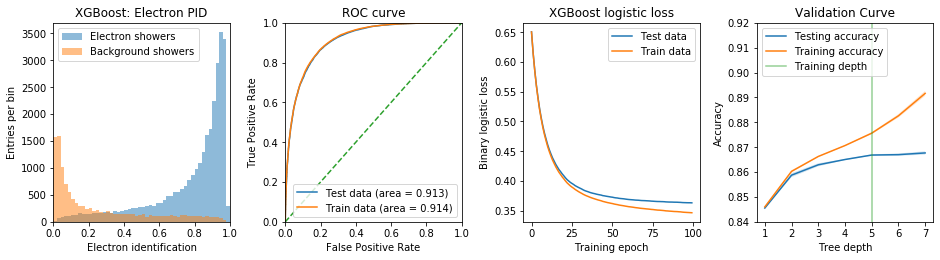

<IPython.core.display.Javascript object>

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_e.predict_proba(X_test).T[0]
y_pred_train = model_e.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["train_label"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"Electron showers",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Background showers",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Electron PID")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_e.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")

if train_ana:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax[3].set_title("Validation Curve")
    ax[3].set_xlabel(r"Tree depth")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_ylim(0.84, 0.92)
    ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
    ax[3].fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
    )
    ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
    ax[3].fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
    )
    ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
    ax[3].legend(loc="upper left")
    ax[3].set_xticks(param_range)

fig.savefig(output_dir + "training/e_bdt_test.pdf")

#### Other daughters training

In [41]:
train_q = "preselect & ~e_candidate"
for k in ["train"]:
    X = train["daughters"].query(train_q)[col_train_other]
    Y = train["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )

<IPython.core.display.Javascript object>

In [42]:
# fit model on training data
depth = 6
if retrain:
    model_d = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_d.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_d, model_dir + "model_d.pckl")
else:
    model_d = load(model_dir + "model_d.pckl")

<IPython.core.display.Javascript object>

In [43]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.86      0.86      0.86     70952
muon, overlay, photon       0.76      0.76      0.76     40134

             accuracy                           0.83    111086
            macro avg       0.81      0.81      0.81    111086
         weighted avg       0.83      0.83      0.83    111086

Test accuracy: 82.50%
Train accuracy: 82.49%

1. feature trk_llr_pid_score_v (0.446998)
2. feature trk_distance_v (0.198393)
3. feature trk_score_v (0.104736)
4. feature e_candidate_anglediff (0.064935)
5. feature pfp_trk_daughters_v (0.063038)
6. feature pfp_shr_daughters_v (0.036279)
7. feature pfp_generation_v (0.032373)
8. feature shr_subclusters_v (0.026885)
9. feature hits_per_tklen_v (0.026364)


<IPython.core.display.Javascript object>

In [44]:
if train_ana:
    param_range = range(1, 8)
    train_scores, test_scores = validation_curve(
        XGBClassifier(),
        X_train,
        y_train["train_label"],
        param_name="max_depth",
        param_range=param_range,
        scoring="accuracy",
        n_jobs=2,
        cv=2,
    )

<IPython.core.display.Javascript object>

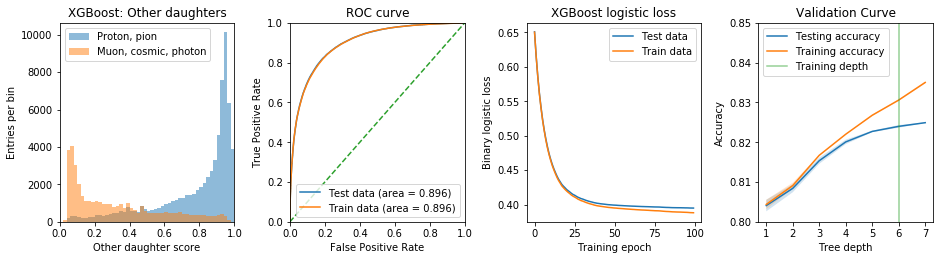

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_d.predict_proba(X_test).T[0]
y_pred_train = model_d.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["train_label"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"Proton, pion",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Muon, cosmic, photon",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Other daughter score")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Other daughters")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_d.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")

if train_ana:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax[3].set_title("Validation Curve")
    ax[3].set_xlabel(r"Tree depth")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_ylim(0.8, 0.85)
    ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
    ax[3].fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
    )
    ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
    ax[3].fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
    )
    ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
    ax[3].legend(loc="upper left")
    ax[3].set_xticks(param_range)

fig.savefig(output_dir + "training/daughter_bdt_test.pdf")

#### Apply models on the samples!

In [48]:
%%time
# add the columns for each daughter (all samples)
for k, v in all_samples.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


CPU times: user 13 s, sys: 1.9 s, total: 14.9 s
Wall time: 4.71 s


<IPython.core.display.Javascript object>

#### Train on the events

In [49]:
%%time
# First we need to add some columns:
for k, v in all_samples.items():    
    print(k)
    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = 1
    
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = 1
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = 1
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .min()
        .values
    )

on
off
nu
dirt
train
CPU times: user 7.02 s, sys: 1.71 s, total: 8.73 s
Wall time: 4.52 s


<IPython.core.display.Javascript object>

In [52]:
train_q = "preselect & e_candidate"
train["daughters"]["nuecclabel"] = train["daughters"].eval(
    "nueccinc & backtracked_purity>0.5 & backtracked_completeness>0.5 & true_vtx_distance<10"
)
X = train["daughters"].query(train_q)[col_train_event]
Y = train["daughters"].query(train_q)[["nuecclabel", "train_weight"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

<IPython.core.display.Javascript object>

In [53]:
# fit model on training data
depth = 5
if retrain:
    model_event = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["nuecclabel"]), (X_test, y_test["nuecclabel"])]
    model_event.fit(
        X_train,
        y_train["nuecclabel"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_event, model_dir + "model_event.pckl")
else:
    model_event = load(model_dir + "model_event.pckl")

<IPython.core.display.Javascript object>

In [54]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nuecclabel"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nuecclabel"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nuecclabel"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.92      0.92      0.92     31524
background events       0.77      0.78      0.77     10852

         accuracy                           0.88     42376
        macro avg       0.85      0.85      0.85     42376
     weighted avg       0.88      0.88      0.88     42376

Test accuracy: 88.30%
Train accuracy: 88.51%

1. feature score (0.715204)
2. feature score_other_mean (0.083267)
3. feature n_showers (0.031736)
4. feature score_other_min (0.029563)
5. feature score_other_max (0.028807)
6. feature all_end_contained (0.027985)
7. feature contained_fraction (0.024178)
8. feature hits_ratio (0.021441)
9. feature n_pfp_farvtx (0.020195)
10. feature all_start_contained (0.017625)


<IPython.core.display.Javascript object>

In [55]:
if train_ana:
    param_range = range(1, 8)
    train_scores, test_scores = validation_curve(
        XGBClassifier(),
        X_train,
        y_train["nuecclabel"],
        param_name="max_depth",
        param_range=param_range,
        scoring="accuracy",
        n_jobs=2,
    )

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<IPython.core.display.Javascript object>

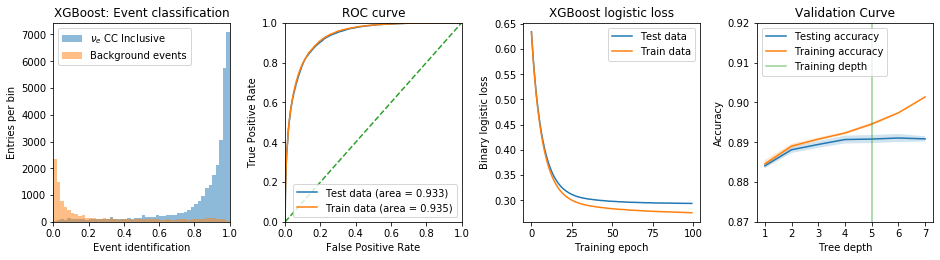

<IPython.core.display.Javascript object>

In [57]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_event.predict_proba(X_test).T[0]
y_pred_train = model_event.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["nuecclabel"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["nuecclabel"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["nuecclabel"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nuecclabel"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Event classification")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_event.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")

if train_ana:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax[3].set_title("Validation Curve")
    ax[3].set_xlabel(r"Tree depth")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_ylim(0.87, 0.92)
    ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
    ax[3].fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
    )
    ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
    ax[3].fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
    )
    ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
    ax[3].legend(loc="upper left")
    ax[3].set_xticks(param_range)

fig.savefig(output_dir + "training/event_bdt_test.pdf")

In [ ]:
%time
# add the columns for each daughter (all samples)
for k, v in all_samples.items():
    print(k)
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

In [ ]:
cut_val = 0.84
query_select = "e_candidate & preselect & score_event>@cut_val"

In [ ]:
%%time
# Passing rate pre-selection
for k, v in all_samples.items():
    v['daughters']['select']=v['daughters'].eval(query_select)
    pass_rate = v["daughters"]['select'].sum()/v['numentries']
    print("{} pass rate\t{:.2%}".format(k,pass_rate))
    
    if k=='train':
        for kind, name in {83: 'bnb', 81: 'lowe'}.items():
            sig_mask = (v["mc"]['sample']==kind) & v["mc"]['nueccinc']
            total_sig = v["mc"]["weightSplineTimesTune"][sig_mask].sum()
            pass_nuecc = v["daughters"].query('select').query("sample==@kind & nueccinc")['weightSplineTimesTune'].sum()/total_sig
            print("\t{}\t{:.2%}".format(name,pass_nuecc))
    if k=='nu':
        total_sig = v["mc"]["weightSplineTimesTune"][v["mc"]["nueccinc"]].sum()
        pass_nuecc = v["daughters"].query('select').query("nueccinc")["weightSplineTimesTune"].sum()/ total_sig
        print("\t{}\t{:.2%}".format("bnb", pass_nuecc))

In [ ]:
# purity
pass_nuecc = (
    all_samples["nu"]["daughters"]
    .query("nueccinc & select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_nu = (
    all_samples["nu"]["daughters"]
    .query("select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .query("select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
)
pass_off = (
    all_samples["off"]["daughters"]["select"].sum() * all_samples["off"]["scaling"]
)
pass_on = all_samples["on"]["daughters"]["select"].sum()

print("nuecc-purity: {:.1%}".format(pass_nuecc / (pass_nu + pass_dirt + pass_off)))
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

In [ ]:
np.savetxt(
    output_dir + "events_nuecc_selected.txt",
    all_samples["on"]["daughters"].query("(e_candidate & select)")[
        ["run", "sub", "evt"]
    ],
    fmt="%u",
)
all_samples["on"]["daughters"].query("(e_candidate & select)")

In [ ]:
all_samples["on"]["daughters"].query("(e_candidate & preselect)")["score_event"].hist(
    range=(0.8, 1), bins=20
)
plt.axvline(x=cut_val, c="r")

In [ ]:
cols_to_pickle = [
    "run",
    "sub",
    "evt",
    "topological_score",
    "n_pfps",
    "n_showers",
    "n_tracks",
    "reco_nu_vtx_sce_x",
    "reco_nu_vtx_sce_y",
    "reco_nu_vtx_sce_z",
    "crtveto",
    "crthitpe",
    "slclustfrac",
    "hits_ratio",
    "CosmicIPAll3D",
    "CosmicDirAll3D",
    "contained_fraction",
    "slpdg",
    "NeutrinoEnergy2",
    "trk_score_v",
    "trk_distance_v",
    "trk_theta_v",
    "trk_phi_v",
    "trk_len_v",
    "trk_llr_pid_score_v",
    "trk_mcs_muon_mom_v",
    "trk_range_muon_mom_v",
    "trk_sce_end_x_v",
    "trk_sce_end_y_v",
    "trk_sce_end_z_v",
    "trk_sce_start_x_v",
    "trk_sce_start_y_v",
    "trk_sce_start_z_v",
    "shr_dist_v",
    "shr_energy_y_v",
    "shr_phi_v",
    "shr_theta_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_tkfit_nhits_v",
    "shr_tkfit_dedx_nhits_y_v",
    "shr_moliere_avg_v",
    "pfpplanesubclusters_U",
    "pfpplanesubclusters_V",
    "pfpplanesubclusters_Y",
    "pfnhits",
    "pfp_generation_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    "_closestNuCosmicDist",
    "ismerged",
    "merge_bestdist",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_dir",
    "secondshower_Y_anglediff",
    "trkshrhitdist2",
    "interaction",
    "weightSplineTimesTune",
    "leeweight",
    "nu_e",
    "nu_pdg",
    "nueccinc",
    "npion",
    "npi0",
    "nproton",
    "nelec",
    "nmuon",
    "nu_purity_from_pfp",
    "backtracked_pdg",
    "backtracked_e",
    "backtracked_completeness",
    "backtracked_purity",
    "backtracked_overlay_purity",
    "backtracked_px",
    "backtracked_py",
    "backtracked_pz",
    "backtracked_start_x",
    "backtracked_start_y",
    "backtracked_start_z",
    "reco_fid_vol",
    "all_start_contained",
    "all_end_contained",
    "n_pfpvtx",
    "n_pfp_farvtx",
    "e_candidate",
    "shr_tkfit_dedx_wm_v",
    "hits_per_tklen_v",
    "shr_subclusters_v",
    "shr_tkfit_hitratio_v",
    "true_vtx_distance",
    "e_candidate_anglediff",
    "preselect",
    "score",
    "score_other_max",
    "score_other_mean",
    "score_other_min",
    "score_event",
    "select",
    "event_scale",
]

In [ ]:
print([x for x in cols_to_pickle if cols_to_pickle.count(x) > 1])
print([x for x in cols_to_pickle if x not in all_samples["nu"]["daughters"]])

In [ ]:
write_output_to_pickle = True
if write_output_to_pickle:
    for sample in list(all_samples.keys()):
        if sample in plot_samples:
            print(sample)
            columns_to_drop = set(all_samples[sample]["daughters"].keys()) - set(
                cols_to_pickle
            )
            all_samples[sample]["daughters"].drop(columns_to_drop, inplace=True, axis=1)
        else:
            del all_samples[sample]
    pickle_out = open(input_dir + "after_training.pckl", "wb")
    pickle.dump(all_samples, pickle_out)
    pickle_out.close()
del train
gc.collect()

### Plots

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    all_samples["nu"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

reco_nu_vtx_sce_x = (
    all_samples["nu"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")["reco_nu_vtx_sce_x"]
)
true_nu_vtx_x = all_samples["nu"]["mc"]["true_nu_vtx_x"][
    (all_samples["nu"]["mc"]["nueccinc"] > 0) & (all_samples["nu"]["mc"]["n_pfps"] > 0)
]
ax[1].hist(
    true_nu_vtx_x + x_sce_magic - reco_nu_vtx_sce_x,
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)

ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")